### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Рассматриваем j-ю итерацию бустинга ($F^j(x_i)$)
1) MSE
$$target_j = -\frac{\partial L(F^{j-1}(x_i), y_i)}{\partial F^{j-1}(x_i)} = 2(y_i - F^{j-1}(x_i))$$
2) Экспоненциальная
$$target_j = -\frac{\partial L(F^{j-1}(x_i), y_i)}{\partial F^{j-1}(x_i)} = y_i e^{-F^{j-1}(x_i)y_i}$$
3) Логистическая
$$target_j = -\frac{\partial L(F^{j-1}(x_i), y_i)}{\partial F^{j-1}(x_i)} = \frac{y_i e^{-F^{j-1}(x_i)y_i}}{1 + e^{-F^{j-1}(x_i)y_i}} = \frac{y_i}{1 + e^{F^{j-1}(x_i)y_i}}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from scipy.special import softmax

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss="log_loss", learning_rate=0.1, n_estimators=100, colsample=1.0, subsample=0.1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.model_args = args
        self.model_kwargs = kwargs
        self.__targets = {
                            "mse"      : self.__mse_target,
                            "exp"      : self.__exp_target,
                            "log_loss" : self.__log_loss_target
                         }
        self.__models = []
        self.__features_history = []
        self.__dimension = 1
        
    def __mse_target(self, preds, y_true):
        """
        Целевая переменная для MSE
        """
        return 2 * (y_true - preds)
    
    def __exp_target(self, preds, y_true):
        """
        Целевая переменная для экспоненциальной функции потерь
        """
        return y_true * np.exp(-preds * y_true)
    
    def __log_loss_target(self, preds, y_true):
        """
        Целевая переменная для логической
        """
        return y_true / (1. + np.exp(preds * y_true))
    
    def __run_init_model(self, X, y, init_model):
        """
        Запуск инициирующей модели
        """
        if init_model != None:
            init_model.fit(X, y)
            self.__models.append(init_model)
            self.__features_history.append(np.arange(X.shape[1]))
            return init_model.predict(X)
        else:
            if y.shape[0] != y.size:
                self.__dimension = y.shape[1]
                return np.zeros((y.shape[0], y.shape[1]))
            else:
                return np.zeros(y.shape[0])
        return None
    
    def __transform_target(self, y):
        """
        Преобразование таргета
        Для mse приводим к, возможно, многоклассовой классификации
        Для остальных преобразуем в -1, 1
        P.S. без этого не получилось выбить нужный скор
        """
        if self.loss != "mse":
            return 2 * y - 1 
        else:
            classes = np.unique(y)
            new_y = np.zeros((y.shape[0], classes.shape[0]))
            for i, j in enumerate(y):
                new_y[i, j] = 1
            return new_y
        return None
        
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для последнего задания)
        """
        y = self.__transform_target(y)
        current_preds = self.__run_init_model(X, y, init_model)
        number_of_features = int(X.shape[1] * self.colsample)
        number_of_objects = int(X.shape[0] * self.subsample)
        for iteration in range(self.n_estimators):
            features = np.random.choice(X.shape[1], number_of_features, replace=False) 
            objects = np.random.choice(X.shape[0], number_of_objects)
            target = self.__targets[self.loss](current_preds[objects], y[objects])
            model = base_model(*self.model_args, **self.model_kwargs)
            model.fit(X[objects][:, features], target)
            self.__models.append(model)
            self.__features_history.append(features)
            current_preds += self.learning_rate * model.predict(X[:, features])

    def predict(self, X):
        if self.__dimension != 1:
            preds = np.zeros((X.shape[0], self.__dimension))
        else:
            preds = np.zeros(X.shape[0])
        for i, model in enumerate(self.__models):
            preds += self.learning_rate * model.predict(X[:, self.__features_history[i]])
        if self.loss == "mse":
            return softmax(preds, axis=1).argmax(axis=1)
        return (preds > 0).astype('int')
    
    def get_params(self, deep=True):
        """
        Для совместимости с sklearn-функциями
        """
        params = {
            "loss"          : self.loss,
            "learning_rate" : self.learning_rate,
            "n_estimators"  : self.n_estimators,
            "colsample"     : self.colsample,
            "subsample"     : self.subsample
        }
        return params
    
    def set_params(self, **kwargs):
        """
        Для совместимости с sklearn-функциями
        """
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                self.model_kwargs[key] = value
        return self

In [3]:
my_clf = MyGradientBoostingClassifier(loss="mse")
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [9]:
sns.set_style("darkgrid")

In [28]:
n_estimators = [10, 50, 100, 250, 500, 750, 1000, 1250, 1500]
scores = []
for i in n_estimators:
    s = cross_val_score(MyGradientBoostingClassifier(n_estimators=i), X, y, cv=3, scoring="accuracy")
    scores.append(s.mean())

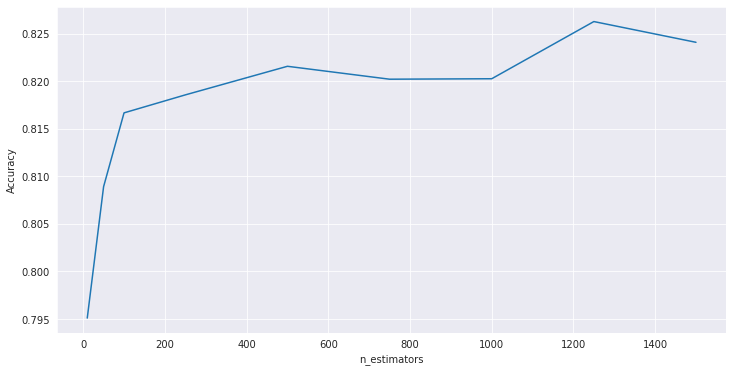

In [29]:
plt.figure(figsize=(12,6))
plt.plot(n_estimators, scores)
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.show()

Оптимальное количество - 1250 итераций. Подберем оптимальные параметры с помощью RandomizedSearchCV

In [30]:
grid = {
    "loss": ("mse", "log_loss", "exp"),
    "learning_rate": (0.1, 0.05, 0.01, 0.005),
    "colsample": (0.5, 0.7, 0.9),
    "subsample": (0.5, 0.7, 0.9),
    "max_depth": (3, 5, 7)
}
search = RandomizedSearchCV(MyGradientBoostingClassifier(n_estimators=1250), 
                            grid, verbose=3, cv=3, scoring="accuracy", n_iter=15)

In [32]:
search.fit(X, y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END colsample=0.7, learning_rate=0.1, loss=mse, max_depth=5, subsample=0.7;, score=0.782 total time=  36.7s
[CV 2/3] END colsample=0.7, learning_rate=0.1, loss=mse, max_depth=5, subsample=0.7;, score=0.836 total time=  34.2s
[CV 3/3] END colsample=0.7, learning_rate=0.1, loss=mse, max_depth=5, subsample=0.7;, score=0.785 total time=  35.5s
[CV 1/3] END colsample=0.5, learning_rate=0.05, loss=exp, max_depth=5, subsample=0.7;, score=0.812 total time=  28.0s
[CV 2/3] END colsample=0.5, learning_rate=0.05, loss=exp, max_depth=5, subsample=0.7;, score=0.859 total time=  29.0s
[CV 3/3] END colsample=0.5, learning_rate=0.05, loss=exp, max_depth=5, subsample=0.7;, score=0.798 total time=  25.9s
[CV 1/3] END colsample=0.9, learning_rate=0.05, loss=exp, max_depth=7, subsample=0.9;, score=0.807 total time= 1.2min
[CV 2/3] END colsample=0.9, learning_rate=0.05, loss=exp, max_depth=7, subsample=0.9;, score=0.862 total time= 1.2mi

RandomizedSearchCV(cv=3,
                   estimator=<__main__.MyGradientBoostingClassifier object at 0x7f7e31188d10>,
                   n_iter=15,
                   param_distributions={'colsample': (0.5, 0.7, 0.9),
                                        'learning_rate': (0.1, 0.05, 0.01,
                                                          0.005),
                                        'loss': ('mse', 'log_loss', 'exp'),
                                        'max_depth': (3, 5, 7),
                                        'subsample': (0.5, 0.7, 0.9)},
                   scoring='accuracy', verbose=3)

In [33]:
(search.best_params_, search.best_score_)

({'colsample': 0.9,
  'learning_rate': 0.05,
  'loss': 'exp',
  'max_depth': 7,
  'subsample': 0.9},
 0.8271317829457364)

Скор на валидации у лучшей модели - 0.8271




## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [16]:
cv = KFold(n_splits=3)
result = []
for train_index, test_index in cv.split(X):
    model = MyGradientBoostingClassifier(loss ='exp', n_estimators=40,
                                         learning_rate=0.1, colsample=0.7, subsample=0.7)
    model.fit(X[train_index], y[train_index], base_model=RandomForestRegressor)
    result.append(accuracy_score(y[test_index], model.predict(X[test_index])))
print(np.mean(np.array(result)))

0.8184108527131783


In [17]:
from sklearn.ensemble import BaggingClassifier

In [18]:
model = MyGradientBoostingClassifier(loss ='exp', n_estimators=80,
                                         learning_rate=0.1, colsample=0.7, subsample=0.7)

In [19]:
np.mean(cross_val_score(BaggingClassifier(base_estimator=model, n_estimators=10),
                        X, y, cv=3, scoring="accuracy"))

0.7510174418604652

В случае бустинга качество немного упало. Скорее всего, это вызвано тем, что плохо подобраны параметры модели в этом случае, к томе же количество моделей в этом случае небольшое. Но в то же время, возможно, мы исчерпали обобщающую способность на этих данных обычными деревьями

В случае бэгинга над бустингом качество заметно упало. Скорее всего, это вызвано плохим подбором параметров. Также, вполне возможно переобучение

**Замечание**: более детальный подбор параметров или большее количество моделей использовать не получилось, так как не влезал в доступную оперативку :(

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [12]:
cv = KFold(n_splits=3)
result = []
for train_index, test_index in cv.split(X):
    model = MyGradientBoostingClassifier(loss ='exp', n_estimators=1250,
                                         learning_rate=0.05, colsample=0.9, subsample=0.9)
    model.fit(X[train_index], y[train_index], init_model=RandomForestRegressor())
    result.append(accuracy_score(y[test_index], model.predict(X[test_index])))
print(np.mean(np.array(result)))

0.8186046511627908


In [13]:
cv = KFold(n_splits=3)
result = []
for train_index, test_index in cv.split(X):
    model = MyGradientBoostingClassifier(loss ='exp', n_estimators=1250,
                                         learning_rate=0.05, colsample=0.9, subsample=0.9)
    model.fit(X[train_index], y[train_index], init_model=LinearRegression())
    result.append(accuracy_score(y[test_index], model.predict(X[test_index])))
print(np.mean(np.array(result)))

0.8147771317829458


In [14]:
cv = KFold(n_splits=3)
result = []
for train_index, test_index in cv.split(X):
    model = MyGradientBoostingClassifier(loss ='exp', n_estimators=1250,
                                         learning_rate=0.05, colsample=0.9, subsample=0.9)
    model.fit(X[train_index], y[train_index], init_model=SVR())
    result.append(accuracy_score(y[test_index], model.predict(X[test_index])))
print(np.mean(np.array(result)))

0.8160368217054264


Качество улучшить не получилось. Скорее всего, это связано с тем, что под эти модели не были подобраны оптимальные параметры, но в то же время возможно, что более сильные модели в инициализации приводили к тому, что базовые модели хуже обучались и, как следствие, падала точность

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Ансамбли были очень хорошо расказаны!

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

Было бы круто иметь альтернативные данные, чтобы нормально разобраться с BooBag и BagBoo, а не получать переполнение оперативки при любом движении

